# AIM

DQN  
Breakout-v0

# REFERENCE

* [https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

In [1]:
import copy
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, optimizers, Variable, serializers
import cv2

In [26]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "matplotlib", "gym", "opencv-python"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
matplotlib 2.0.2
gym 0.9.2
opencv-python 3.3.0.9


In [27]:
env = gym.make("Breakout-v0")

[2017-09-03 11:55:16,235] Making new env: Breakout-v0


(210, 160, 3) [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


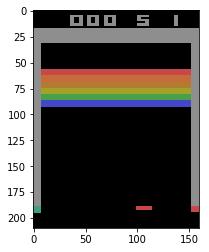

In [28]:
%matplotlib inline

pobs = env.reset()

# 次元の確認
print(pobs.shape, pobs)

# 画面の確認
plt.imshow(pobs)
plt.show()

デフォルト


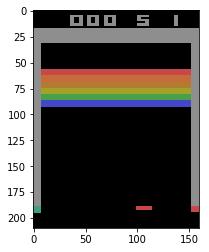

グレースケールに変換


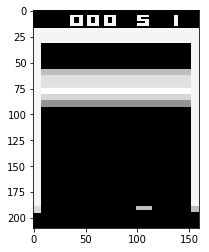

リサイズ
(210, 160)
(105, 80)


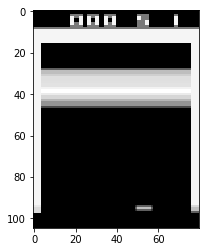

必要な部分のみにカット
(50, 70)


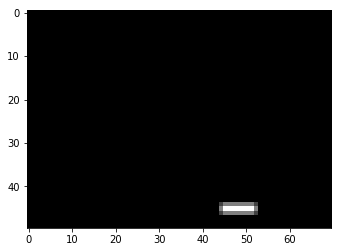

In [29]:
%matplotlib inline

pobs = env.reset()

print("デフォルト")
plt.imshow(pobs, cmap="gray")
plt.show()

print("グレースケールに変換")
pobs = cv2.cvtColor(pobs, cv2.COLOR_RGB2GRAY)
plt.imshow(pobs, cmap="gray")
plt.show()

print("リサイズ")
print(pobs.shape)
height, width = pobs.shape
size = (int(width * 0.5), int(height * 0.5))
pobs = cv2.resize(pobs, size)
print(pobs.shape)
plt.imshow(pobs, cmap="gray")
plt.show()

print("必要な部分のみにカット")
pobs = pobs[50:100, 5:75]
print(pobs.shape)
plt.imshow(pobs, cmap="gray")
plt.show()

<IPython.core.display.Javascript object>


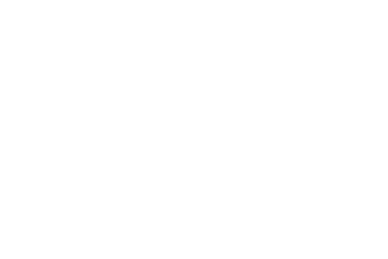

<IPython.core.display.Javascript object>


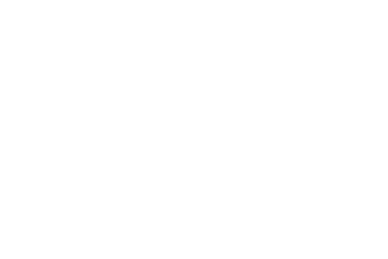

In [30]:
%matplotlib nbagg

fig = plt.figure()

pobs = env.reset()
im = plt.imshow(pobs, animated=True)

def render(*args):
    pobs, _, _, _ = env.step(env.action_space.sample())
    im.set_array(pobs)
    return im

ani = animation.FuncAnimation(fig, render, interval=10)
plt.show()

<IPython.core.display.Javascript object>


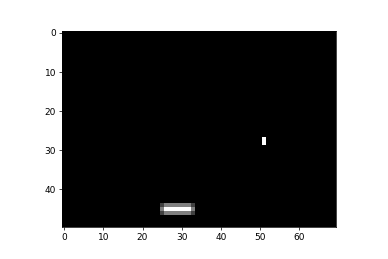

In [31]:
%matplotlib nbagg

fig = plt.figure()

def convert(obs):
    # グレースケール
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    # リサイズ
    height, width = obs.shape
    size = (int(width*0.5), int(height*0.5))
    obs = cv2.resize(obs, size)
    # カット
    obs = obs[50:100, 5:75]
    return obs

pobs = env.reset()
pobs = convert(pobs)
im = plt.imshow(pobs, cmap="gray", animated=True)

def render(*args):
    pobs, _, _, _ = env.step(env.action_space.sample())
    pobs = convert(pobs)
    im.set_array(pobs)
    return im

ani = animation.FuncAnimation(fig, render, interval=10)
plt.show()

In [10]:
# 環境
env = gym.make("Breakout-v0")

# CNNクラス定義
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__(
            xc = L.Convolution2D(None, 48, (5, 70)),
            ch = L.Linear(1104, 300),
            hy = L.Linear(300, env.action_space.n)
        )
        
    def __call__(self, x):
        x = Variable(x)
        h = F.max_pooling_2d(F.relu(self.xc(x)), 2)
        h = F.relu(self.ch(h))
        y = F.relu(self.hy(h))
        return y
        
    def reset(self):
        self.zerograds()

# 画像変換関数定義
def convert(obs):
    # グレースケール
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    # リサイズ
    height, width = obs.shape
    size = (int(width*0.5), int(height*0.5))
    obs = cv2.resize(obs, size)
    # カット
    obs = obs[50:100, 5:75]
    # 正規化
    obs = obs/255
    # CNNが読み込める形式にする
    obs = np.array(obs, dtype="float32")
    return obs

# モデル
Q = CNN() # 近似Q関数
#serializers.load_npz("./******.npz", q) # 重みファイル読み込み
Q_ast = copy.deepcopy(Q)
optimizer = optimizers.Adam()
optimizer.setup(Q)

# 定数
EPOCH_NUM = 10000 # エポック数
MEMORY_SIZE = 1000 # メモリサイズいくつで学習を開始するか
BATCH_SIZE = 100 # バッチサイズ
EPSILON = 1 # ε-greedy法
EPSILON_DECREASE = 0.01 # εの減少値
EPSILON_MIN = 0.01 # εの下限
START_REDUCE_EPSILON = 10000 # εを減少させるステップ数
TRAIN_FREQ = 10 # Q関数の学習間隔
UPDATE_TARGET_Q_FREQ = 20 # Q関数の更新間隔
GAMMA = 0.99

total_step = 0 # 総ステップ（行動）数
memory = [] # メモリ
total_rewards = [] # 累積報酬記録用リスト
total_losses = [] # 累積誤差記録用リスト

# 学習開始
print("Train")
print("\t".join(["epoch", "EPSILON", "reward", "total_step", "loss", "elapsed_time"]))
start = time.time()
for epoch in range(EPOCH_NUM):
    pobs = env.reset() # 環境初期化
    pobs = convert(pobs)
    converted_height, converted_width = pobs.shape[0], pobs.shape[1] # 後で利用するので、変換後のサイズを取得
    done = False # ゲーム終了フラグ
    total_reward = 0 # 累積報酬
    total_loss = 0 # 累積誤差
    pact = 0
    while not done:
        if total_step % 4 != 0: # フレームスキップ
            env.step(pact) # フレーム間は同じ行動を選択
        else:
            # 行動選択
            pact = env.action_space.sample()
            if np.random.rand() > EPSILON: # ε-greedy法
                pact = Q(pobs.reshape((1, 1, converted_height, converted_width))) # 最適な行動を予測 # batchsize, channel, height, width
                pact = np.argmax(pact.data)
            # 行動
            obs, reward, done, _ = env.step(pact)
            obs = convert(obs)
            # メモリに蓄積
            memory.append((pobs, pact, reward, obs, done)) # 変換済みの行動前状態ベクトル、未変換の行動ラベル、報酬、変換済みの行動後状態ベクトル、ゲーム終了フラグ
            if len(memory) > MEMORY_SIZE: # メモリサイズを超えていれば消していく
                memory.pop(0)
            # 学習
            if len(memory) == MEMORY_SIZE: # メモリサイズ分溜まっていれば学習
                # 経験リプレイ
                if total_step % TRAIN_FREQ == 0:
                    np.random.shuffle(memory)
                    memory_idx = range(len(memory))
                    for i in memory_idx[::BATCH_SIZE]:
                        batch = np.array(memory[i:i+BATCH_SIZE]) # 経験ミニバッチ
                        pobss = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, 1, converted_height, converted_width))
                        pacts = np.array(batch[:,1].tolist(), dtype="int32")
                        rewards = np.array(batch[:,2].tolist(), dtype="int32")
                        obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, 1, converted_height, converted_width))
                        dones = np.array(batch[:,4].tolist(), dtype="bool")
                        # set y
                        q = Q(pobss)
                        maxq = list(map(np.max, Q_ast(obss).data)) # maxQ
                        target = copy.deepcopy(q.data)
                        for j in range(BATCH_SIZE):
                            target[j, pacts[j]] = rewards[j]+GAMMA*maxq[j]*(not dones[j])
                        # Perform a gradient descent step
                        Q.reset()
                        loss = F.mean_squared_error(q, Variable(target))
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()
                # Q関数の更新
                if total_step % UPDATE_TARGET_Q_FREQ == 0:
                    Q_ast = copy.deepcopy(Q)
            # εの減少
            if EPSILON > EPSILON_MIN:
                if total_step > START_REDUCE_EPSILON:
                    EPSILON -= EPSILON_DECREASE
        # 次の行動へ
        total_reward += reward
        total_step += 1
        pobs = obs
    total_rewards.append(total_reward) # 累積報酬を記録
    total_losses.append(total_loss) # 累積誤差を記録
    #serializers.save_npz("./******.npz", q) # 重みファイル出力
    if (epoch+1) % 10 == 0:
        elapsed_time = time.time()-start
        r = sum(total_rewards[((epoch+1)-10):(epoch+1)])
        l = sum(total_losses[((epoch+1)-10):(epoch+1)])
        print("\t".join(map(str,[epoch+1, EPSILON, r, total_step, l, str(elapsed_time)+"[sec]"]))) # ログ出力
        start = time.time()
        
plt.figure(figsize=(15,7))
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.show()

[2017-09-08 15:34:24,316] Making new env: Breakout-v0


Train
epoch	EPSILON	reward	total_step	loss	elapsed_time
10	1	4.0	2565	0	1.8546431064605713[sec]
20	1	24.0	6221	52.8624945751	92.8125901222229[sec]
30	1	24.0	9481	4447.01745101	137.496808052063[sec]
40	0.009999999999999247	4.0	12365	61724.9275609	120.54328298568726[sec]
50	0.009999999999999247	12.0	15265	357849.963881	123.7274010181427[sec]
60	0.009999999999999247	24.0	19585	605129.479257	183.9136209487915[sec]
70	0.009999999999999247	12.0	23565	339378.376717	166.3626208305359[sec]
80	0.009999999999999247	28.0	27677	864616.077669	171.95793104171753[sec]
90	0.009999999999999247	12.0	32089	1491195.17068	215.8324019908905[sec]
100	0.009999999999999247	16.0	37245	384950.992886	284.71415400505066[sec]
110	0.009999999999999247	20.0	43989	173042.988264	332.6061131954193[sec]
120	0.009999999999999247	0.0	47453	295326.91113	153.32349801063538[sec]
130	0.009999999999999247	12.0	50793	373432.465396	142.37874293327332[sec]
140	0.009999999999999247	0.0	54729	314481.638469	169.33896803855896[sec]
150

1120	0.009999999999999247	16.0	493493	191.332248611	235.7824718952179[sec]
1130	0.009999999999999247	20.0	498121	172.227592369	207.4320900440216[sec]
1140	0.009999999999999247	4.0	502801	197.128045195	208.83222913742065[sec]
1150	0.009999999999999247	16.0	508081	375.297552168	235.67582201957703[sec]
1160	0.009999999999999247	28.0	513041	486.533978125	221.66685509681702[sec]
1170	0.009999999999999247	16.0	517237	422.649319442	187.0431411266327[sec]
1180	0.009999999999999247	20.0	521021	299.537519452	170.04006695747375[sec]
1190	0.009999999999999247	28.0	525185	395.262512558	185.86479306221008[sec]
1200	0.009999999999999247	24.0	528765	473.421508472	160.2539758682251[sec]
1210	0.009999999999999247	40.0	532881	468.623592179	184.20719504356384[sec]
1220	0.009999999999999247	16.0	535721	643.758227371	128.2271020412445[sec]
1230	0.009999999999999247	16.0	538745	5151.84678295	135.52504014968872[sec]
1240	0.009999999999999247	12.0	541521	6130.15414634	124.96079802513123[sec]
1250	0.00999999999

2210	0.009999999999999247	24.0	1050677	4.19099156207	513.6008241176605[sec]
2220	0.009999999999999247	0.0	1052577	0.549467262023	87.49651098251343[sec]
2230	0.009999999999999247	0.0	1054409	0.526140003654	84.61308002471924[sec]
2240	0.009999999999999247	4.0	1056289	0.697695279639	86.48754405975342[sec]
2250	0.009999999999999247	4.0	1059797	1.40141828751	161.19575595855713[sec]
2260	0.009999999999999247	8.0	1061825	0.987602798622	93.888179063797[sec]
2270	0.009999999999999247	4.0	1063669	0.985911173538	84.86037683486938[sec]
2280	0.009999999999999247	0.0	1065437	0.923440655259	81.0477979183197[sec]
2290	0.009999999999999247	4.0	1067417	1.06509640526	91.11950206756592[sec]
2300	0.009999999999999247	4.0	1069233	1.10820293661	83.85279512405396[sec]
2310	0.009999999999999247	4.0	1071097	1.07881643895	85.79051089286804[sec]
2320	0.009999999999999247	8.0	1072953	0.980223743867	85.780277967453[sec]
2330	0.009999999999999247	8.0	1074709	1.65392162124	81.01283097267151[sec]
2340	0.00999999999999

3290	0.009999999999999247	16.0	1795209	2.4384346541	543.7265310287476[sec]
3300	0.009999999999999247	8.0	1796977	0.659574206171	81.48984503746033[sec]
3310	0.009999999999999247	8.0	1803113	2.02550661508	282.64600706100464[sec]
3320	0.009999999999999247	28.0	1820257	5.40789110801	787.8714709281921[sec]
3330	0.009999999999999247	8.0	1830989	1.66039204764	494.4242980480194[sec]
3340	0.009999999999999247	8.0	1850037	1.22100143661	876.2210640907288[sec]
3350	0.009999999999999247	4.0	1857241	0.468409987571	332.5575478076935[sec]
3360	0.009999999999999247	12.0	1863965	0.584280853455	311.150936126709[sec]
3370	0.009999999999999247	12.0	1889053	2.56854114194	1155.5008189678192[sec]
3380	0.009999999999999247	4.0	1890973	0.50293537948	88.33053398132324[sec]
3390	0.009999999999999247	0.0	1893201	0.330269301886	103.07650017738342[sec]
3400	0.009999999999999247	8.0	1895045	0.419120476556	85.16449403762817[sec]
3410	0.009999999999999247	0.0	1897161	0.293826842643	97.77825999259949[sec]
3420	0.0099999

4370	0.009999999999999247	0.0	2398005	0.445422592291	77.40441298484802[sec]
4380	0.009999999999999247	4.0	2399929	0.430512344301	88.42939519882202[sec]
4390	0.009999999999999247	12.0	2410821	1.38387685864	501.88425302505493[sec]
4400	0.009999999999999247	16.0	2419109	1.09361238198	380.5348958969116[sec]
4410	0.009999999999999247	20.0	2421433	1.92264118596	106.856605052948[sec]
4420	0.009999999999999247	0.0	2423297	4.60289382201	85.72187519073486[sec]
4430	0.009999999999999247	0.0	2425061	4.19744093944	82.03671097755432[sec]
4440	0.009999999999999247	0.0	2426729	3.81412389046	76.5838041305542[sec]
4450	0.009999999999999247	0.0	2428377	3.70074189958	75.6816840171814[sec]
4460	0.009999999999999247	0.0	2430141	3.97194776488	82.21587014198303[sec]
4470	0.009999999999999247	4.0	2432097	3.75567062991	89.50991201400757[sec]
4480	0.009999999999999247	4.0	2434337	0.653881584212	103.35049891471863[sec]
4490	0.009999999999999247	8.0	2453433	1.7655335427	878.7282211780548[sec]
4500	0.00999999999999

KeyboardInterrupt: 